# Overview

This notebook explores building a deep learning model that predicts the probability that a news story is about health and wellness. There are two distict Tensorflow DistillBERT models in this notebook, and a separate notebook that evaluates the same data set using Torch BERT models.

# Imports

In [50]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

import time
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
import json
import glob
import json
import numpy as np
print(tf.__version__)


2.18.0


The data comes from Kaggle's News Category database:
https://www.kaggle.com/rmisra/news-category-dataset/version/2

In [52]:
ROOT_DIR = "define_your_root_dir"
DATA_DIR = "%s" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = "%s/models" % ROOT_DIR

In [53]:
import pandas as pd
import numpy as np
reviews = pd.read_json('%s/news_category_trainingdata.json' % DATA_DIR)
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']
reviews['healthy'] = np.where((reviews['category'] == 'HEALTHY LIVING'), 1, 0)

sample_amount = 6694

healthy = reviews[reviews['healthy'] == 1]
not_healthy = reviews[reviews['healthy'] == 0].sample(n=sample_amount)

review_sample = pd.concat([healthy,not_healthy])
target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']

#Preparing the Data

In [54]:
from sklearn.model_selection import train_test_split

The first thing we need to do is prepare the data. Specifically, we have a categorical column that we want to turn into a "is this article healthy living?" column. That is, when an article is about healthy living, it should have a 1, when it's anything else, it should be a 0.

# Test, Tune and Save Models

In [55]:
!pip install tensorflow transformers

In [56]:
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [57]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
bert_model = TFDistilBertModel.from_pretrained(MODEL_NAME)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
def preprocess_texts(texts, tokenizer, maxlen=512):
    """
    Tokenize input texts for the Transformer model.
    Returns a dictionary of input IDs and attention masks.
    """
    return tokenizer(
        list(texts),
        padding='max_length',  # <-- set this to 'max_length'
        truncation=True,
        max_length=maxlen,
        return_tensors="tf"
    )

# Split the data
X = review_sample['combined_text'].values  # Input texts
y = review_sample['healthy'].values       # Binary labels (0 or 1)

# Train-test split (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the tokenizer
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# Tokenize training and validation data
train_encodings = preprocess_texts(X_train, tokenizer, maxlen=512)
val_encodings = preprocess_texts(X_val, tokenizer, maxlen=512)

In [ ]:
# Convert labels to tensors
train_labels = tf.convert_to_tensor(y_train)
val_labels = tf.convert_to_tensor(y_val)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from transformers import TFDistilBertModel

# 1) Load DistilBERT
bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

# 2) Define Input Layers
input_ids = Input(shape=(512,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(512,), dtype=tf.int32, name="attention_mask")

# 3) Create a function that calls DistilBERT and returns the last hidden state
def distilbert_call(inputs):
    """
    inputs[0] = input_ids (shape: (batch_size, 512))
    inputs[1] = attention_mask (shape: (batch_size, 512))
    """
    output = bert_model(
        input_ids=inputs[0],
        attention_mask=inputs[1],
        training=False
    ))
    return output.last_hidden_state

# 4) Use a Lambda layer to transform inputs
bert_output = Lambda(
    distilbert_call,
    output_shape=(512, 768)  # DistilBERT hidden_size is 768
)([input_ids, attention_mask])

# 5) Extract the [CLS] token (first token) for classification
def take_cls_token(tensor):
    return tensor[:, 0, :]

cls_token_output = Lambda(take_cls_token, output_shape=(768,))(bert_output)

# 6) Add classification layers
x = Dropout(0.3)(cls_token_output)
output = Dense(1, activation="sigmoid")(x)  # Binary classification => 1 output node

# 7) Build and Compile Model
model = Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 512, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 768)            │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 768)            │              0 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │            769 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x={
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"]
    },
    y=train_labels,
    validation_data=(
        {
            "input_ids": val_encodings["input_ids"],
            "attention_mask": val_encodings["attention_mask"]
        },
        val_labels
    ),
    epochs=3,
    batch_size=16
)



Epoch 1/3
670/670 ━━━━━━━━━━━━━━━━━━━━ 236s 353ms/step - accuracy: 0.6044 - loss: 0.6578 - val_accuracy: 0.7240 - val_loss: 0.6136
Epoch 2/3
670/670 ━━━━━━━━━━━━━━━━━━━━ 291s 396ms/step - accuracy: 0.6703 - loss: 0.6234 - val_accuracy: 0.7591 - val_loss: 0.5844
Epoch 3/3
670/670 ━━━━━━━━━━━━━━━━━━━━ 318s 390ms/step - accuracy: 0.6999 - loss: 0.5982 - val_accuracy: 0.7700 - val_loss: 0.5622


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get model predictions on validation set
y_pred_prob = model.predict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"]
})

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Convert labels to NumPy array if necessary
y_true = np.array(val_labels)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"])
print(report)


84/84 ━━━━━━━━━━━━━━━━━━━━ 52s 541ms/step
              precision    recall  f1-score   support

     Class 0       0.80      0.72      0.76      1339
     Class 1       0.74      0.82      0.78      1339

    accuracy                           0.77      2678
   macro avg       0.77      0.77      0.77      2678
weighted avg       0.77      0.77      0.77      2678



These f1-scrores are high, which could be caused by overfitting. But a strong outcome for this Tensorflow model build on a Transformers.

In [ ]:
import pandas as pd

# Convert classification report to dictionary
report_dict = classification_report(y_true, y_pred, output_dict=True)

# Convert to DataFrame
df_tf_results = pd.DataFrame(report_dict).transpose()


In [ ]:
df_tf_results.to_csv("tf_results.csv", index=True)

In [64]:
from transformers import DistilBertTokenizerFast
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenization function
def tokenize_texts(texts, labels, max_length=512):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding="max_length",  # Ensures all sequences are of length 512
        max_length=max_length,
        return_tensors="tf"
    )
    return encodings, tf.convert_to_tensor(labels, dtype=tf.float32)  # Ensure labels are tensors


# Splitting dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    review_sample["combined_text"], review_sample["healthy"], test_size=0.1, random_state=42
)

# Tokenize the dataset again with fixed length padding
train_encodings, train_labels = tokenize_texts(train_texts, train_labels)
val_encodings, val_labels = tokenize_texts(val_texts, val_labels)

# Convert to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    train_labels
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    val_labels
)).batch(16)



In [65]:
import tensorflow as tf
from transformers import TFDistilBertModel

def build_model(learning_rate=1e-4, dropout_rate=0.3):
    # Load DistilBERT model
    bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

    # Define Input Layers
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name="attention_mask")

    # Use Lambda to process DistilBERT output and specify `output_shape`
    bert_output = tf.keras.layers.Lambda(
        lambda x: bert_model(input_ids=x[0], attention_mask=x[1], training=False).last_hidden_state,
        output_shape=(512, 768)  # Explicitly specify output shape: (sequence_length, hidden_size)
    )([input_ids, attention_mask])

    # Extract CLS token (first token)
    cls_output = tf.keras.layers.Lambda(lambda x: x[:, 0, :], output_shape=(768,))(bert_output)

    # Add dropout and classification layer
    x = tf.keras.layers.Dropout(rate=dropout_rate)(cls_output)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)  # Binary classification

    # Define Model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [ ]:
# Build and train the model
model = build_model()
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3, batch_size=16)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/3
754/754 ━━━━━━━━━━━━━━━━━━━━ 238s 303ms/step - accuracy: 0.5944 - loss: 0.6641 - val_accuracy: 0.7797 - val_loss: 0.5556
Epoch 2/3
754/754 ━━━━━━━━━━━━━━━━━━━━ 259s 303ms/step - accuracy: 0.7386 - loss: 0.5568 - val_accuracy: 0.7916 - val_loss: 0.5044
Epoch 3/3
754/754 ━━━━━━━━━━━━━━━━━━━━ 229s 304ms/step - accuracy: 0.7624 - loss: 0.5173 - val_accuracy: 0.7991 - val_loss: 0.4786


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get model predictions on validation set
y_pred_prob = model.predict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"]
})

# Convert probabilities to binary predictions (assuming threshold of 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Convert labels to NumPy array if necessary
y_true = np.array(val_labels)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"])
print(report)

42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 630ms/step
              precision    recall  f1-score   support

     Class 0       0.81      0.79      0.80       668
     Class 1       0.79      0.81      0.80       671

    accuracy                           0.80      1339
   macro avg       0.80      0.80      0.80      1339
weighted avg       0.80      0.80      0.80      1339



For this second Tensorflow DistillBERT model, tokenization was added and the f1-scores increased.

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 512, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 768)            │              0 │ lambda_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 768)            │              0 │ lambda_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            769 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,309 (9.02 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,540 (6.02 KB)

In [ ]:
import pandas as pd

# Convert classification report to dictionary
report_dict = classification_report(y_true, y_pred, output_dict=True)

# Convert to DataFrame
df_tf_results = pd.DataFrame(report_dict).transpose()
df_tf_results.to_csv("custom_dbert_tf_results.csv", index=True)

100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 277ms/step - accuracy: 0.7411 - loss: 0.5175


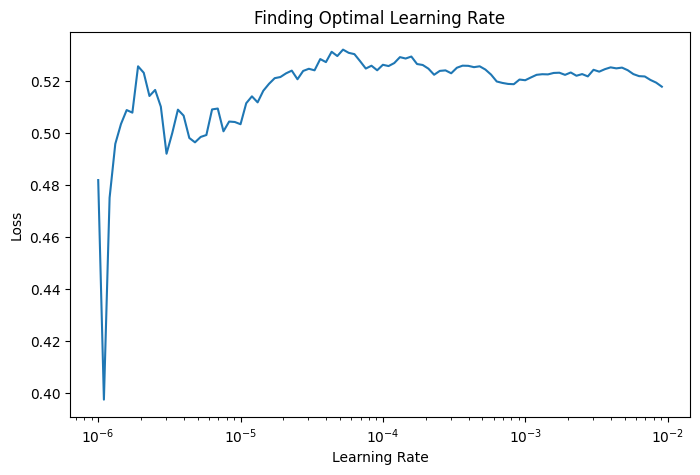

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Learning Rate Scheduler Callback
class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, start_lr=1e-6, end_lr=1e-2, num_iters=100):
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_iters = num_iters
        self.lr_mult = (end_lr / start_lr) ** (1 / num_iters)
        self.history = []

    def on_train_begin(self, logs=None):
        """Set the initial learning rate at the beginning of training"""
        self.model.optimizer.learning_rate.assign(self.start_lr)

    def on_train_batch_end(self, batch, logs=None):
        """Adjust the learning rate at the end of each batch"""
        lr = self.model.optimizer.learning_rate.numpy()
        self.history.append((lr, logs["loss"]))
        self.model.optimizer.learning_rate.assign(lr * self.lr_mult)

# Apply LR Finder
lr_finder = LRFinder()
model.fit(train_dataset.take(100), epochs=1, callbacks=[lr_finder], verbose=1)

# Plot Learning Rate vs Loss
lrs, losses = zip(*lr_finder.history)
plt.figure(figsize=(8, 5))
plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Finding Optimal Learning Rate")
plt.show()




This plot shows the results of hyperparameter tuning using learning rate evolution.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("checkpoint/distilbert_model.keras", save_best_only=True)

# Train Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=12,
    batch_size=16,
    callbacks=[early_stopping, checkpoint]
)



Epoch 1/12
754/754 ━━━━━━━━━━━━━━━━━━━━ 229s 304ms/step - accuracy: 0.7756 - loss: 0.4719 - val_accuracy: 0.8290 - val_loss: 0.3941
Epoch 2/12
754/754 ━━━━━━━━━━━━━━━━━━━━ 229s 303ms/step - accuracy: 0.7897 - loss: 0.4626 - val_accuracy: 0.8051 - val_loss: 0.4147
Epoch 3/12
754/754 ━━━━━━━━━━━━━━━━━━━━ 229s 303ms/step - accuracy: 0.7891 - loss: 0.4688 - val_accuracy: 0.8133 - val_loss: 0.4064
Epoch 4/12
754/754 ━━━━━━━━━━━━━━━━━━━━ 229s 303ms/step - accuracy: 0.7891 - loss: 0.4691 - val_accuracy: 0.8260 - val_loss: 0.3897
Epoch 5/12
754/754 ━━━━━━━━━━━━━━━━━━━━ 280s 327ms/step - accuracy: 0.7871 - loss: 0.4680 - val_accuracy: 0.8267 - val_loss: 0.3915
Epoch 6/12
754/754 ━━━━━━━━━━━━━━━━━━━━ 229s 303ms/step - accuracy: 0.7896 - loss: 0.4645 - val_accuracy: 0.8170 - val_loss: 0.3989
Epoch 7/12
754/754 ━━━━━━━━━━━━━━━━━━━━ 262s 304ms/step - accuracy: 0.7879 - loss: 0.4738 - val_accuracy: 0.8148 - val_loss: 0.4008


Above shows the results of early stopping. Interestingly, the model stops after 7 epochs due to a patience setting of 3. So epoch 4 was where the max accuracy was attained.

In [ ]:
from tensorflow.keras.models import load_model

model.save("distilbertmodel_learner.keras")

loaded_model = load_model("distilbertmodel_learner.keras", safe_mode=False)


In [ ]:
def predict_text(text, model):
    encodings = tokenizer(text, truncation=True, padding=True, max_length=512, return_tensors="tf")
    logits = model.predict({"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"]})
    proba = logits[0][0]  # Probability score
    return proba

text = "Diversity is the key to a healthy society."
proba = predict_text(text, model)
print(f"Probability this is healthy: {proba:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Probability this is healthy: 0.8298


In [ ]:
from sklearn.metrics import classification_report

# Get model predictions
y_pred_prob = model.predict(val_dataset)
y_pred = (y_pred_prob > 0.5).astype(int)

# Convert labels
y_true = np.array(val_labels)

# Generate classification report
print(classification_report(y_true, y_pred, target_names=["Not Healthy", "Healthy"]))


84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step
              precision    recall  f1-score   support

 Not Healthy       0.81      0.84      0.83       668
     Healthy       0.84      0.81      0.82       671

    accuracy                           0.83      1339
   macro avg       0.83      0.83      0.83      1339
weighted avg       0.83      0.83      0.83      1339



Great to see higher f1-scores on the validation data set.

# Inspecting the drivers of prediction

Let's go ahead and make a little set of test documents to check out

In [46]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

In [47]:
for i, text in enumerate(test_docs):
    proba = predict_text(text, model)
    print("---------------------------")
    print(f"Document {i+1}:")
    print(f"The probability this is 'healthy' is {proba:.4f}")
    print(text)
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
---------------------------
Document 1:
The probability this is 'healthy' is 0.9742
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
---------------------------
Document 2:
The probability this is 'healthy' is 0.8598
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
---------------------------
Document 3:
The probability this is 'healthy' is 0.2813
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
---------------------------
Document 4:
The probability this is 'healthy' is 0.9046
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan wil

# Bayesian Optimization

In [58]:
!pip install bayesian-optimization
import tensorflow as tf
from bayes_opt import BayesianOptimization
from transformers import DistilBertTokenizerFast, TFDistilBertModel
import numpy as np
from sklearn.model_selection import train_test_split


In [ ]:
# Build and train the model
model = build_model()
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3, batch_size=16)

In [ ]:
def train_and_evaluate(learning_rate, dropout_rate):
    model = build_model(learning_rate, dropout_rate)

    # Train the model
    history = model.fit(
        {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
        train_labels,
        validation_data=(
            {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
            val_labels
        ),
        epochs=3,  # Short training to speed up tuning
        batch_size=16,
        verbose=0  # Suppress excessive output
    )

    # Return final validation accuracy
    val_acc = history.history["val_accuracy"][-1]
    return val_acc


In [ ]:
# Define the hyperparameter search space
pbounds = {
    "learning_rate": (1e-6, 5e-4),  # Small range for fine-grained control
    "dropout_rate": (0.1, 0.5)  # Keep within reasonable range
}

# Create the Bayesian Optimizer
optimizer = BayesianOptimization(
    f=train_and_evaluate,  # Our training function
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Run Bayesian Optimization (10 initial points, 15 iterations)
optimizer.maximize(init_points=10, n_iter=15)

# Print best hyperparameters
print("Best hyperparameters found:", optimizer.max)


|   iter    |  target   | dropou... | learni... |
-------------------------------------------------


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


| 1         | 0.8051    | 0.2498    | 0.0004754 |


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
